In [1]:
import urllib.parse
import urllib.request
import pandas as pd
import re
from tqdm.notebook import tqdm
import numpy as np
import pickle
import missingno as msno
import multiprocessing 
from multiprocessing import Manager, Pool
num_cores = int(110)
import random
from datar import f
from datar.dplyr import mutate, filter, if_else
from datar.tibble import tibble
from preprocessing import parallelize_dataframe

[2022-11-07 03:43:58][datar][WARNING] Builtin name "filter" has been masked by datar.


In [2]:
# load data : key: kinase, value: sequence
with open('/home/hb/python/phospho/kw/1traintruedata생성/mappingdict(KIN_ACC_ID)HMM.pickle', 'rb') as fr:
    mappingdict = pickle.load(fr)

# 정답 데이터
df1 = pd.read_csv('/home/hb/python/phospho/kw/1traintruedata생성/Kinase_Substrate_Dataset',encoding = 'ISO-8859-1', header = 2, delimiter = '\t') 
print(df1.columns)
df1.tail()

Index(['GENE', 'KINASE', 'KIN_ACC_ID', 'KIN_ORGANISM', 'SUBSTRATE',
       'SUB_GENE_ID', 'SUB_ACC_ID', 'SUB_GENE', 'SUB_ORGANISM', 'SUB_MOD_RSD',
       'SITE_GRP_ID', 'SITE_+/-7_AA', 'DOMAIN', 'IN_VIVO_RXN', 'IN_VITRO_RXN',
       'CST_CAT#'],
      dtype='object')


,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>
21224,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
21225,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
21226,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN
21227,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESsPILTsFELVKVP,NaN,X,,13857
21228,ULK2,ULK2,Q8IYT8,human,DENND3,22898.0,A2RUS2,DENND3,human,S472,7997148,THRRMVVsMPNLQDI,NaN,,X,NaN


In [3]:
df2 = df1.dropna(subset=['KIN_ACC_ID'])
print(df2.columns)
df2.reset_index(drop=True, inplace=True)
df2.tail()

Index(['GENE', 'KINASE', 'KIN_ACC_ID', 'KIN_ORGANISM', 'SUBSTRATE',
       'SUB_GENE_ID', 'SUB_ACC_ID', 'SUB_GENE', 'SUB_ORGANISM', 'SUB_MOD_RSD',
       'SITE_GRP_ID', 'SITE_+/-7_AA', 'DOMAIN', 'IN_VIVO_RXN', 'IN_VITRO_RXN',
       'CST_CAT#'],
      dtype='object')


,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>
21221,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
21222,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
21223,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN
21224,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESsPILTsFELVKVP,NaN,X,,13857
21225,ULK2,ULK2,Q8IYT8,human,DENND3,22898.0,A2RUS2,DENND3,human,S472,7997148,THRRMVVsMPNLQDI,NaN,,X,NaN


In [4]:
df2['KIN_ACC_ID'] = df2['KIN_ACC_ID'].apply(lambda x:x.replace("-2","")
                                            .replace("-3","")
                                            .replace("-8","")
                                            .replace("-10",""))
df2['KIN_ACC_ID'].unique()
df2.reset_index(drop=True, inplace=True)
df2.tail()

/tmp/ipykernel_385360/2962801615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['KIN_ACC_ID'] = df2['KIN_ACC_ID'].apply(lambda x:x.replace("-2","")


,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>
21221,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
21222,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
21223,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN
21224,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESsPILTsFELVKVP,NaN,X,,13857
21225,ULK2,ULK2,Q8IYT8,human,DENND3,22898.0,A2RUS2,DENND3,human,S472,7997148,THRRMVVsMPNLQDI,NaN,,X,NaN


In [5]:
df2 = df2[df2['KIN_ACC_ID'].isin(mappingdict.keys())]
df2.reset_index(drop=True, inplace=True)
df2.tail()

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>
17716,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
17717,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
17718,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN
17719,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESsPILTsFELVKVP,NaN,X,,13857
17720,ULK2,ULK2,Q8IYT8,human,DENND3,22898.0,A2RUS2,DENND3,human,S472,7997148,THRRMVVsMPNLQDI,NaN,,X,NaN


In [6]:
df2

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>
0,Dyrk2,DYRK2,Q5U4C9,mouse,NDEL1,83431.0,Q9ERR1,Ndel1,mouse,S336,1869686801,LGSsRPSsAPGMLPL,NaN,,X,NaN
1,Pak2,PAK2,Q64303,rat,MEK1,170851.0,Q01986,Map2k1,rat,S298,448284,RtPGRPLsSYGMDSR,Pkinase,,X,9128; 98195
2,Pak2,PAK2,Q64303,rat,PRKD1,85421.0,Q9WTQ1,Prkd1,rat,S203,449896,GVRRRRLsNVsLTGL,NaN,X,,NaN
3,Pak2,PAK2,Q64303,rat,prolactin,24683.0,P01237,Prl,rat,S206,451732,IRCLRRDsHKVDNYL,Hormone_1,,X,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,Pak2,PAK2,Q64303,rat,prolactin,5617.0,P01236,PRL,human,S207,451732,LHCLRRDsHKIDNYL,Hormone_1,,X,NaN
17716,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDtssLtQsAPA,NaN,X,,NaN
17717,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DtssLtQsAPAsPtN,NaN,X,,NaN
17718,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFsVSLSNSH,NaN,X,,NaN


<AxesSubplot:>

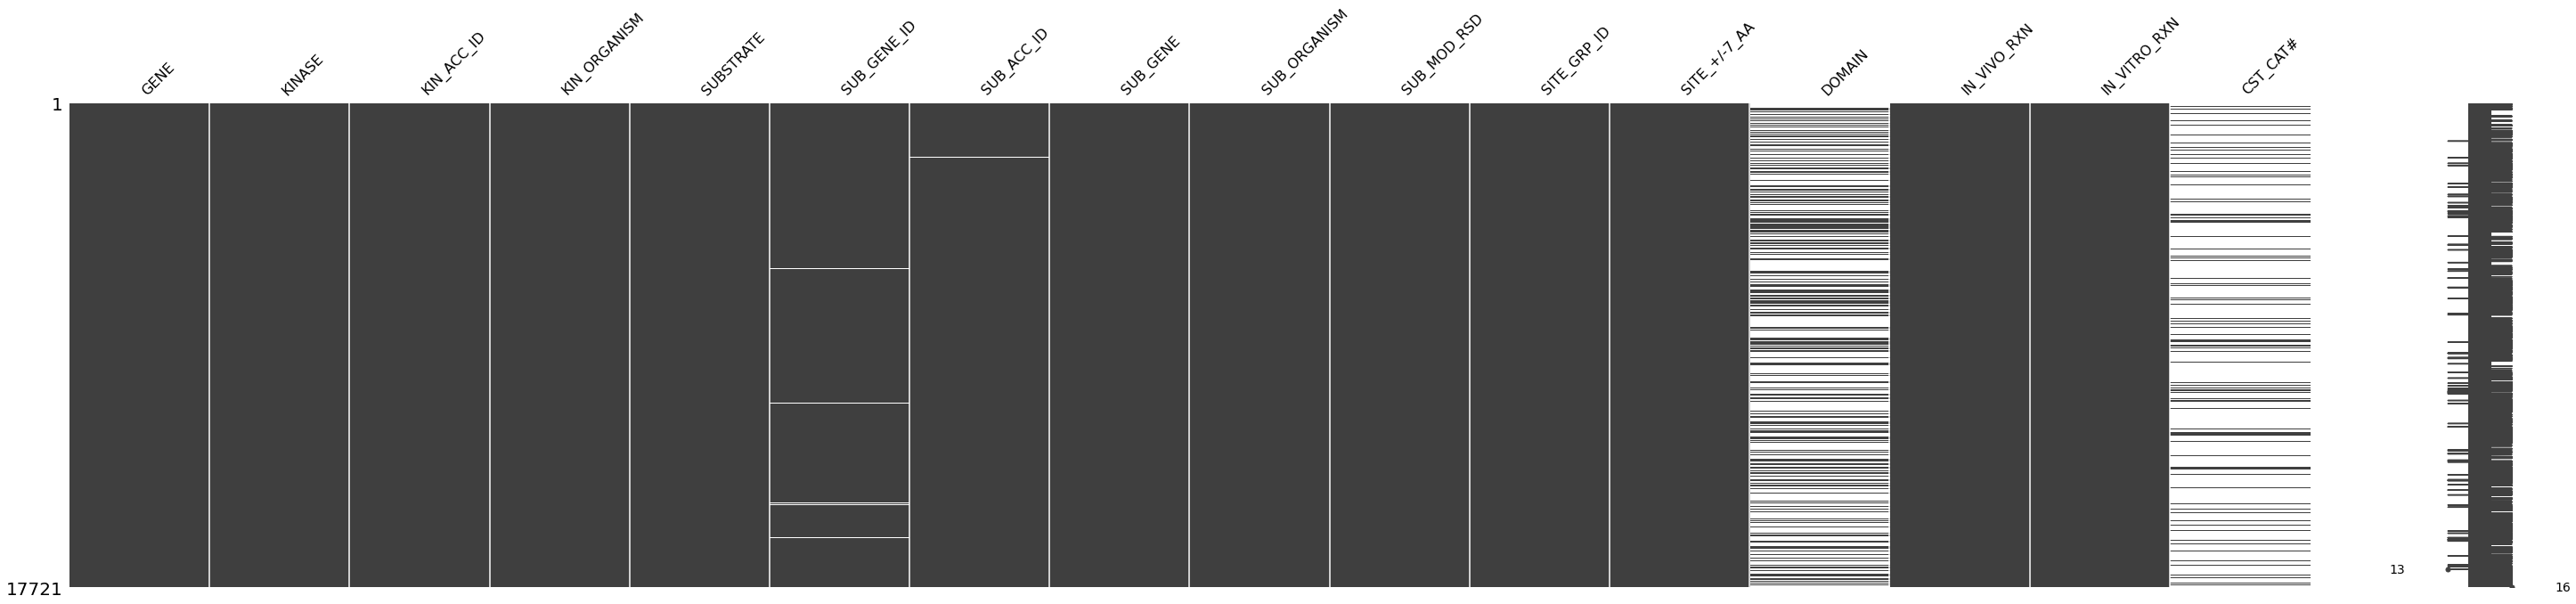

In [7]:
msno.matrix(df2, figsize=(50,10)) # 결측치 조회

amax    336.000000
amin     61.000000
mean    263.058857
Name: Length, dtype: float64


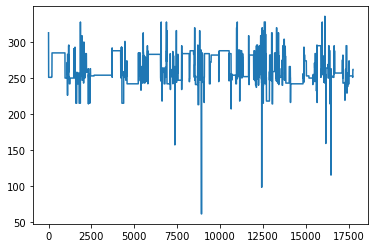

In [8]:
df2['KINseq'] = df2.apply(lambda x: mappingdict[x['KIN_ACC_ID']], axis=1)
df2['Length'] = df2.apply(lambda x: len(x['KINseq']), axis=1)
df2['Length'].plot()
len_info = df2['Length'].agg([np.max, np.min, np.mean])
max_len, min_len, mean_len = len_info
print(len_info)

In [9]:
df2['KINseq'] = df2['KINseq'].apply(lambda x:x.ljust(int(max_len),'0')) # 왼쪽으로 정렬 후 빈 값은 0으로 채워넣기
df2['KINseq'][0]

'YEVLKVIGKGSFGQVVKAYDHKVHQHVALKMVRNEKRFHRQAAEEIRILEHLRKQDKDNTMNVIHMLENFTFRNHICMTFELLSMNLYELIKKNKFQGFSLPLVRKFAHSILQCLDALHKNRIIHCDLKPENILLKQQGRSSIKVIDFGSSCYEHQRVYTYIQSRFYRAPEVILGARYGMPIDMWSLGCILAELLTGYPLLPGEDEGDQLACMIELLGMPSQKLLDASKRAKNFVSSKGYPRYCTVTTLSDGSVVLNGGRSRRGKLRGPPESREWGNALKGCDDPLFLDFLKQCLEWDPAVRMTPGQALRHPW00000000000000000000000'

In [10]:
print('before: ', df2['SITE_+/-7_AA'][:5])
df2['SITE_+/-7_AA'] = df2['SITE_+/-7_AA'].apply(lambda x:x.upper())
print('after: ', df2['SITE_+/-7_AA'][:5])

before:  0    LGSsRPSsAPGMLPL
1    RtPGRPLsSYGMDSR
2    GVRRRRLsNVsLTGL
3    IRCLRRDsHKVDNYL
4    LHCLRRDsHKIDNYL
Name: SITE_+/-7_AA, dtype: object
after:  0    LGSSRPSSAPGMLPL
1    RTPGRPLSSYGMDSR
2    GVRRRRLSNVSLTGL
3    IRCLRRDSHKVDNYL
4    LHCLRRDSHKIDNYL
Name: SITE_+/-7_AA, dtype: object


In [11]:
df2['answer'] = 1
df2.tail()

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#,KINseq,Length,answer
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>,<object>,<int64>,<int64>
17716,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDTSSLTQSAPA,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
17717,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DTSSLTQSAPASPTN,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
17718,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFSVSLSNSH,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
17719,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESSPILTSFELVKVP,NaN,X,,13857,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
17720,ULK2,ULK2,Q8IYT8,human,DENND3,22898.0,A2RUS2,DENND3,human,S472,7997148,THRRMVVSMPNLQDI,NaN,,X,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1


In [12]:
df3 = df2.drop_duplicates(['KINseq', 'SITE_+/-7_AA'])
df3.reset_index(drop=True, inplace=True)
df3.tail()

,GENE,KINASE,KIN_ACC_ID,KIN_ORGANISM,SUBSTRATE,SUB_GENE_ID,SUB_ACC_ID,SUB_GENE,SUB_ORGANISM,SUB_MOD_RSD,SITE_GRP_ID,SITE_+/-7_AA,DOMAIN,IN_VIVO_RXN,IN_VITRO_RXN,CST_CAT#,KINseq,Length,answer
,<object>,<object>,<object>,<object>,<object>,<float64>,<object>,<object>,<object>,<object>,<int64>,<object>,<object>,<object>,<object>,<object>,<object>,<int64>,<int64>
16626,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S855,3205935,QRVLDTSSLTQSAPA,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
16627,ULK2,ULK2,Q8IYT8,human,Raptor,57521.0,Q8N122,RPTOR,human,S859,2024885,DTSSLTQSAPASPTN,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
16628,ULK2,ULK2,Q8IYT8,human,SEC16A,9919.0,O15027,SEC16A,human,S846,55578720,LAQPINFSVSLSNSH,NaN,X,,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
16629,ULK2,ULK2,Q8IYT8,human,PIK3C3,5289.0,Q8NEB9,PIK3C3,human,S249,35483209,ESSPILTSFELVKVP,NaN,X,,13857,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1
16630,ULK2,ULK2,Q8IYT8,human,DENND3,22898.0,A2RUS2,DENND3,human,S472,7997148,THRRMVVSMPNLQDI,NaN,,X,NaN,YSKRDLVGHGAFAVVFRGRHRQKTDWEVAIKSINKKNLSKSQILLG...,262,1


## Make False data

In [13]:
hash_data = pd.read_csv("/home/hb/python/phospho/kw/1traintruedata생성/Calpha.txt", sep='\t')
display(hash_data.tail())
hash_data.drop(columns=['Unnamed: 0'], inplace=True)
display(hash_data.tail())
print(hash_data.columns)
characters = tuple(hash_data.columns)


,Unnamed: 0,L,F,I,M,V,W,C,Y,H,...,T,G,P,R,Q,S,N,E,D,K
,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,...,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
15,S,0.020,-0.076,-0.025,0.000,0.021,-0.004,-0.191,-0.023,0.032,...,-0.017,-0.013,0.201,0.127,0.090,-0.108,0.024,0.196,0.060,0.178
16,N,0.139,0.039,0.043,0.080,0.139,0.028,-0.038,-0.003,0.133,...,0.033,0.048,0.288,0.209,0.053,0.024,-0.205,0.245,0.036,0.117
17,E,0.016,0.128,0.049,0.036,0.096,0.058,0.202,0.145,0.232,...,0.134,0.240,0.428,-0.157,0.106,0.196,0.245,0.181,0.396,-0.182
18,D,0.169,0.150,0.123,0.136,0.148,0.167,0.097,0.165,0.083,...,0.087,0.137,0.366,-0.038,0.130,0.060,0.036,0.396,0.301,-0.006
19,K,0.043,0.024,-0.014,0.121,0.057,0.017,0.156,-0.013,0.373,...,0.165,0.179,0.496,0.350,0.121,0.178,0.117,-0.182,-0.006,0.205


,L,F,I,M,V,W,C,Y,H,A,T,G,P,R,Q,S,N,E,D,K
,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
15,0.020,-0.076,-0.025,0.000,0.021,-0.004,-0.191,-0.023,0.032,-0.031,-0.017,-0.013,0.201,0.127,0.090,-0.108,0.024,0.196,0.060,0.178
16,0.139,0.039,0.043,0.080,0.139,0.028,-0.038,-0.003,0.133,0.046,0.033,0.048,0.288,0.209,0.053,0.024,-0.205,0.245,0.036,0.117
17,0.016,0.128,0.049,0.036,0.096,0.058,0.202,0.145,0.232,-0.012,0.134,0.240,0.428,-0.157,0.106,0.196,0.245,0.181,0.396,-0.182
18,0.169,0.150,0.123,0.136,0.148,0.167,0.097,0.165,0.083,0.073,0.087,0.137,0.366,-0.038,0.130,0.060,0.036,0.396,0.301,-0.006
19,0.043,0.024,-0.014,0.121,0.057,0.017,0.156,-0.013,0.373,0.075,0.165,0.179,0.496,0.350,0.121,0.178,0.117,-0.182,-0.006,0.205


Index(['L', 'F', 'I', 'M', 'V', 'W', 'C', 'Y', 'H', 'A', 'T', 'G', 'P', 'R',
       'Q', 'S', 'N', 'E', 'D', 'K'],
      dtype='object')


In [14]:
df3['singleSITE'] = df3['SITE_+/-7_AA'].apply(lambda x: tuple(x))
df3['singleSITE'][:5]

/tmp/ipykernel_385360/979842099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['singleSITE'] = df3['SITE_+/-7_AA'].apply(lambda x: tuple(x))


0    (L, G, S, S, R, P, S, S, A, P, G, M, L, P, L)
1    (R, T, P, G, R, P, L, S, S, Y, G, M, D, S, R)
2    (G, V, R, R, R, R, L, S, N, V, S, L, T, G, L)
3    (I, R, C, L, R, R, D, S, H, K, V, D, N, Y, L)
4    (L, H, C, L, R, R, D, S, H, K, I, D, N, Y, L)
Name: singleSITE, dtype: object

In [15]:
# # 무슨 코든지 모르겠으면 주석 풀고 보길
# from collections import Counter
# characters_sum = {i:0 for i in characters}
# print('시작', characters_sum)
# for row in df3['singleSITE'][:2]:
#     row_counter = Counter(row)
#     print(row_counter)
#     for key, value in row_counter.items():
#         characters_sum[key] = characters_sum[key] + value 
#     print('1 cycle 종료', characters_sum)
#     print('=='*20)

In [16]:
from collections import Counter

def calculate_aa_sum(df):
    characters_sum = {i:0 for i in characters}

    for row in df['singleSITE']:
        row_counter = Counter(row)
        for key, value in row_counter.items():
            if key == '_':
                pass
            else: 
                characters_sum[key] = characters_sum[key] + value 
    return characters_sum

In [17]:
aa_sum = calculate_aa_sum(df3)

In [18]:
all_counts = sum(aa_sum.values())
aa_indexes = tuple(aa_sum.keys())
dfop = pd.DataFrame({'aa_counts':aa_sum.values()}, index=aa_indexes)
dfop.sort_index(inplace=True)
dfop['ratio'] = dfop['aa_counts'].apply(lambda x: x/sum(dfop['aa_counts']))

percentage = dfop['ratio']
total = sum(dfop['aa_counts'])
repeats = np.around(np.array(percentage) * total).astype(np.int64)  # [6, 3, 2]
characters = np.repeat(aa_indexes, repeats)
userId   = ''.join([random.choice(characters) for _ in range(15)]) #aa의 frequency에 따라 출현율 차등
df_false = df3.copy()

def make_false_aa_seq(a):
    left = [random.choice(characters) for _ in range(7)]
    middle = [random.choice(['S', 'Y', 'T'])]
    right = [random.choice(characters) for _ in range(7)]
    aa = "".join(left+middle+right)
    return aa

df_false['answer'] = 0
df_false['SITE_+/-7_AA'] = ''   
df_false['SITE_+/-7_AA'] = df_false['SITE_+/-7_AA'].apply(make_false_aa_seq)

df = pd.concat([df3, df_false],axis=0)

In [19]:
# #비율맞춰서 False data 만들기 
# hash_data = pd.read_csv('/home/hb/python/phospho/kw/1traintruedata생성/Calpha.txt', sep='\t')
# del hash_data['Unnamed: 0']
# hash_data.columns
# characters = hash_data.columns
# characters
# df2['singleSITE'] = df2['SITE_+/-7_AA'].apply(lambda x:list(x))
# valuestocount = []
# for j in range(17721):
#     for i in df2['singleSITE'].iloc[j]:
#         for n in characters:
#             if i == n:
#                 valuestocount.append(n)

# A = valuestocount.count('A')
# C = valuestocount.count('C')
# D = valuestocount.count('D')
# E = valuestocount.count('E')
# F = valuestocount.count('F')
# G = valuestocount.count('G')
# H = valuestocount.count('H')
# I = valuestocount.count('I')
# K = valuestocount.count('K')
# L = valuestocount.count('L')
# M = valuestocount.count('M')
# N = valuestocount.count('N')
# P = valuestocount.count('P')
# Q = valuestocount.count('Q')
# R = valuestocount.count('R')
# S = valuestocount.count('S')
# T = valuestocount.count('T')
# V = valuestocount.count('V')
# W = valuestocount.count('W')
# Y = valuestocount.count('Y')
# allcount = A + C + D + E + F + G+ H +I +K +L +M +N +P+ Q+ R+ S+ T+ V+ W +Y
# index = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
# dfop = pd.DataFrame({'aacount': [A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y]}, index = index)
# dfop['ratio'] = dfop['aacount'].apply(lambda x:x/allcount)

# percentage = dfop['ratio']
# total = 265815
# repeats = np.around(np.array(percentage) * total).astype(np.int64)  # [6, 3, 2]
# characters = np.repeat(index, repeats)
# userId   = ''.join([random.choice(characters) for _ in range(15)]) #aa의 frequency에 따라 출현율 차등
# dfTemp = df2.copy()
# dfTemp['answer'] = 0
# dfTemp['SITE_+/-7_AA'] = ''
# dfTemp['SITE_+/-7_AA'] = dfTemp['SITE_+/-7_AA'].apply(lambda x:x.join([random.choice(characters) for _ in range(15)]))
# df3 = pd.concat([df2,dfTemp],axis=0)

In [20]:
from collections import namedtuple

kin = df['KIN_ACC_ID'].to_numpy()
kinseq = df['KINseq'].to_numpy()
kinase_seq_info_dict = {key: value 
                        if len(value)==336 else print('error') 
                        for key, value in zip(kin, kinseq)}

In [21]:
hash_data = pd.read_csv('/home/hb/python/phospho/kw/1traintruedata생성/Calpha.txt', sep='\t')
mayproblem = []
for i in kinase_seq_info_dict.values():
    for n in i:
        if n not in hash_data.columns:
            mayproblem.append(i)
mayproblem

['YEVLKVIGKGSFGQVVKAYDHKVHQHVALKMVRNEKRFHRQAAEEIRILEHLRKQDKDNTMNVIHMLENFTFRNHICMTFELLSMNLYELIKKNKFQGFSLPLVRKFAHSILQCLDALHKNRIIHCDLKPENILLKQQGRSSIKVIDFGSSCYEHQRVYTYIQSRFYRAPEVILGARYGMPIDMWSLGCILAELLTGYPLLPGEDEGDQLACMIELLGMPSQKLLDASKRAKNFVSSKGYPRYCTVTTLSDGSVVLNGGRSRRGKLRGPPESREWGNALKGCDDPLFLDFLKQCLEWDPAVRMTPGQALRHPW00000000000000000000000',
 'YEVLKVIGKGSFGQVVKAYDHKVHQHVALKMVRNEKRFHRQAAEEIRILEHLRKQDKDNTMNVIHMLENFTFRNHICMTFELLSMNLYELIKKNKFQGFSLPLVRKFAHSILQCLDALHKNRIIHCDLKPENILLKQQGRSSIKVIDFGSSCYEHQRVYTYIQSRFYRAPEVILGARYGMPIDMWSLGCILAELLTGYPLLPGEDEGDQLACMIELLGMPSQKLLDASKRAKNFVSSKGYPRYCTVTTLSDGSVVLNGGRSRRGKLRGPPESREWGNALKGCDDPLFLDFLKQCLEWDPAVRMTPGQALRHPW00000000000000000000000',
 'YEVLKVIGKGSFGQVVKAYDHKVHQHVALKMVRNEKRFHRQAAEEIRILEHLRKQDKDNTMNVIHMLENFTFRNHICMTFELLSMNLYELIKKNKFQGFSLPLVRKFAHSILQCLDALHKNRIIHCDLKPENILLKQQGRSSIKVIDFGSSCYEHQRVYTYIQSRFYRAPEVILGARYGMPIDMWSLGCILAELLTGYPLLPGEDEGDQLACMIELLGMPSQKLLDASKRAKNFVSSKGYPRYCTVTTLSDGSVVLNGGRSRRGKLRGPPESREWGNALKGCDDPLFLDFLKQCLEWDPAVRMTPGQALRHPW000

In [22]:
# kinase error 체크
problem = []
for kinase_seq in df['SITE_+/-7_AA']:
    assert len(kinase_seq) == 15
    if False in list(map(lambda x: x in list(hash_data.columns), kinase_seq)):
        problem.append(kinase_seq)

In [23]:
df3['Length'].max()

336

In [24]:
hash_data = pd.read_csv('/home/hb/python/phospho/kw/1traintruedata생성/Calpha.txt', sep='\t')
hash_data.set_index(hash_data['Unnamed: 0'], inplace=True)

In [131]:
def make_matrix(df):
   # 해시값 불러오기
    hash_data = pd.read_csv('/home/hb/python/phospho/kw/1traintruedata생성/Calpha.txt', sep='\t')
    hash_data.set_index(hash_data['Unnamed: 0'], inplace=True)
   # 불필요한 칼럼 정리
    del hash_data['Unnamed: 0']
    hash_data = np.exp(-1*hash_data)#ver2
    hash_data_list = []
    
    for amino in kinase_seq_info_dict[df['KIN_ACC_ID']]:
        if amino in hash_data.columns:
            for target in df['SITE_+/-7_AA']:
                if target == '_' or target == 'X' or target == 'U':
                    hash_data_list.append(0)
                else:
                    hash_data_list.append(hash_data[amino][target])   
        elif amino not in hash_data.columns:
            for target in df['SITE_+/-7_AA']:
                hash_data_list.append(0)
   
    if len(df['SITE_+/-7_AA'])==15:
        matrix = np.array(hash_data_list).reshape(1,336,15).astype('float64')
    return matrix

def make_df(df):
    df['matrix'] = df.apply(make_matrix, axis=1)
    return df

def parallelize_dataframe(df, func):
    import numpy as np
    df_split = np.array_split(df, num_cores)
    pool = Pool(num_cores)
    df1 = np.concatenate(pool.map(func, df_split), axis=0)
    pool.close()
    pool.join()
    return df1

In [133]:
df.drop(columns='singleSITE', inplace=True)
df

KeyError: "['singleSITE'] not found in axis"

In [135]:
df4 = parallelize_dataframe(df, make_df)

In [136]:
df4.shape

(33262, 20)

In [139]:
columns = list(df.columns)
columns.append('matrix')

In [48]:
with open( "/home/hb/python/phospho/data/psph.pickle", "wb" ) as file:
   pickle.dump( df4, file)

with open( "/home/hb/python/phospho/data/psph.pickle", "rb" ) as file:
    loaded_data = pickle.load(file)

In [140]:
figureff = pd.DataFrame(df4, columns=columns)
figureff['type'] = figureff['SITE_+/-7_AA'].apply(lambda x:x[7])

In [141]:
figureff['type'].value_counts()

S    16179
T     9050
Y     8030
R        2
I        1
Name: type, dtype: int64

# dbPTM

In [1]:
import pandas as pd
ptm = pd.read_csv("/home/hb/python/phospho/data/Phosphorylation", sep='\t', skiprows=[0], 
                    names=['UniProt_ID', 'UniProt_AC', 'Location', 'Modification', 'Reference', 'Substrate_Peptides'])

In [2]:
ptm.dropna(subset='UniProt_ID', inplace=True)
ptm.reset_index(drop=True, inplace=True)
ptm.tail()

,UniProt_ID,UniProt_AC,Location,Modification,Reference,Substrate_Peptides
1615004,ZRAB2_HUMAN,O95218-2,120.0,Phosphorylation,18669648,ENVEYIEREESDGEYDEFGRK
1615005,ZRAB2_HUMAN,O95218-2,153.0,Phosphorylation,18669648,SILKEVEDKESEGEEEDEDED
1615006,ZRAB2_HUMAN,O95218-2,181.0,Phosphorylation,18669648,EDEDEDDADLSKYNLDASEEE
1615007,ZRAB2_HUMAN,O95218-2,183.0,Phosphorylation,18669648,EDEDDADLSKYNLDASEEEDS
1615008,ZRAB2_HUMAN,O95218-2,188.0,Phosphorylation,18669648,ADLSKYNLDASEEEDSNKKKS


In [3]:
Kinase = ptm['UniProt_ID'].apply(lambda x: x.split('_')[0])
Organism = ptm['UniProt_ID'].apply(lambda x: x.split('_')[1])
ptm.insert(1, 'Kinase', Kinase)
ptm.insert(2, 'Organism', Organism)
ptm.tail()

,UniProt_ID,Kinase,Organism,UniProt_AC,Location,Modification,Reference,Substrate_Peptides
1615004,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218-2,120.0,Phosphorylation,18669648,ENVEYIEREESDGEYDEFGRK
1615005,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218-2,153.0,Phosphorylation,18669648,SILKEVEDKESEGEEEDEDED
1615006,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218-2,181.0,Phosphorylation,18669648,EDEDEDDADLSKYNLDASEEE
1615007,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218-2,183.0,Phosphorylation,18669648,EDEDDADLSKYNLDASEEEDS
1615008,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218-2,188.0,Phosphorylation,18669648,ADLSKYNLDASEEEDSNKKKS


In [5]:
ptm.query('Organism=="HUMAN"')

,UniProt_ID,Kinase,Organism,UniProt_AC,Location,Modification,Reference,Substrate_Peptides
9673,IMA3_HUMAN,IMA3,HUMAN,O00629,24.0,Phosphorylation,18212344,NFKNKGRDLETMRRQRNEVVV
9674,IMA3_HUMAN,IMA3,HUMAN,O00629,60.0,Phosphorylation,29255136;22167270;23927012;18707149;25159151;2...,NVPHEDICEDSDIDGDYRVQN
9675,IMA3_HUMAN,IMA3,HUMAN,O00629,66.0,Phosphorylation,23927012;28674151;25852190;28796482;29978859;2...,ICEDSDIDGDYRVQNTSLEAI
9676,IMA3_HUMAN,IMA3,HUMAN,O00629,71.0,Phosphorylation,30278072;20068231;27050516;28176443;21712546;2...,DIDGDYRVQNTSLEAIVQNAS
9677,IMA3_HUMAN,IMA3,HUMAN,O00629,72.0,Phosphorylation,28464451;30278072;20068231;25159151;21955146;2...,IDGDYRVQNTSLEAIVQNASS
...,...,...,...,...,...,...,...,...
1615004,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218-2,120.0,Phosphorylation,18669648,ENVEYIEREESDGEYDEFGRK
1615005,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218-2,153.0,Phosphorylation,18669648,SILKEVEDKESEGEEEDEDED
1615006,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218-2,181.0,Phosphorylation,18669648,EDEDEDDADLSKYNLDASEEE
1615007,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218-2,183.0,Phosphorylation,18669648,EDEDDADLSKYNLDASEEEDS


In [12]:
ptm_human = ptm.query("Organism=='HUMAN'")

In [14]:
ptm_human['ID'] = ptm_human['Kinase'] + '_' + ptm_human['Substrate_Peptides']

/tmp/ipykernel_389363/3861204037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptm_human['ID'] = ptm_human['Kinase'] + '_' + ptm_human['Substrate_Peptides']


In [16]:
# 중복개수 
ptm_human[ptm_human.duplicated(subset='ID')]

,UniProt_ID,Kinase,Organism,UniProt_AC,Location,Modification,Reference,Substrate_Peptides,ID
12669,AHNK_HUMAN,AHNK,HUMAN,Q09666,1519.0,Phosphorylation,12524745;22499768;27794612;27499020;28348404;2...,KMPKVKMPKFSMPGFKGEGPE,AHNK_KMPKVKMPKFSMPGFKGEGPE
12678,AHNK_HUMAN,AHNK,HUMAN,Q09666,1721.0,Phosphorylation,30814801;22499768;27794612;12524461;27499020;2...,KMPKMKMPKFSMPGFKAEGPE,AHNK_KMPKMKMPKFSMPGFKAEGPE
12684,AHNK_HUMAN,AHNK,HUMAN,Q09666,1856.0,Phosphorylation,30266825;29255136;30395287;22617229;24972180;2...,PEMHFKAPKISMPDVDLHLKG,AHNK_PEMHFKAPKISMPDVDLHLKG
12690,AHNK_HUMAN,AHNK,HUMAN,Q09666,1955.0,Phosphorylation,21882895;22199227;21882899;28857561;30175587;2...,PKLEGDLTGPSVGVEVPDVEL,AHNK_PKLEGDLTGPSVGVEVPDVEL
12691,AHNK_HUMAN,AHNK,HUMAN,Q09666,1986.0,Phosphorylation,27422710;22199227;20068231;30395287;22617229;2...,KFKMPEMHFKTPKISMPDVDL,AHNK_KFKMPEMHFKTPKISMPDVDL
...,...,...,...,...,...,...,...,...,...
1615004,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218-2,120.0,Phosphorylation,18669648,ENVEYIEREESDGEYDEFGRK,ZRAB2_ENVEYIEREESDGEYDEFGRK
1615005,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218-2,153.0,Phosphorylation,18669648,SILKEVEDKESEGEEEDEDED,ZRAB2_SILKEVEDKESEGEEEDEDED
1615006,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218-2,181.0,Phosphorylation,18669648,EDEDEDDADLSKYNLDASEEE,ZRAB2_EDEDEDDADLSKYNLDASEEE
1615007,ZRAB2_HUMAN,ZRAB2,HUMAN,O95218-2,183.0,Phosphorylation,18669648,EDEDDADLSKYNLDASEEEDS,ZRAB2_EDEDDADLSKYNLDASEEEDS


In [7]:
#아래는 dfspsphmm_ratiorandom data로
import pickle
with open( "/home/hb/python/phospho/data/dfpsphmmkinsub.pickle", "rb" ) as file:
    df6 = pickle.load(file)

In [8]:
df7 = pd.DataFrame(df6,columns=['KINseq','SITE_+/-7_AA','type',
                                'matrix'])

In [9]:
df7

,KINseq,SITE_+/-7_AA,type,matrix
0,SRKDLIGHGAFAVVFKGRHREKHDLEVAVKCINKKNLAKSQTLLGK...,STTRPWRSAPPSPPP,S,"[[[1.114, 1.018, 1.018, 0.881, 0.818, 1.004, 0..."
1,SRKDLIGHGAFAVVFKGRHREKHDLEVAVKCINKKNLAKSQTLLGK...,GTENSFPSPKAIPNG,S,"[[[1.013, 1.018, 0.822, 0.976, 1.114, 1.079, 0..."
2,SRKDLIGHGAFAVVFKGRHREKHDLEVAVKCINKKNLAKSQTLLGK...,EPHAKKKSKISASRK,S,"[[[0.822, 0.818, 0.9688, 1.031, 0.837, 0.837, ..."
3,SRKDLIGHGAFAVVFKGRHREKHDLEVAVKCINKKNLAKSQTLLGK...,CHKTKLKSILEILSK,S,"[[[1.211, 0.9688, 0.837, 1.018, 0.837, 0.98, 0..."
4,SRKDLIGHGAFAVVFKGRHREKHDLEVAVKCINKKNLAKSQTLLGK...,TTSTRTYSLGSALRP,S,"[[[1.018, 1.018, 1.114, 1.018, 0.881, 1.018, 1..."
...,...,...,...,...
4166068,GKPLGEGCFGQVVMAEAIGIDKDRAAKPVTVAVKMLKDDATDKDLS...,SPAFDNLYYWDQNSS,Y,"[[[1.013, 0.935, 1.11, 1.02, 0.872, 0.953, 0.9..."
4166069,GKPLGEGCFGQVVMAEAIGIDKDRAAKPVTVAVKMLKDDATDKDLS...,QDHYETDYTTGGESC,Y,"[[[0.8745, 0.872, 1.006, 0.981, 0.7866, 1.027,..."
4166070,GKPLGEGCFGQVVMAEAIGIDKDRAAKPVTVAVKMLKDDATDKDLS...,LKTPSAAYLWVGTGA,Y,"[[[0.912, 0.836, 1.027, 0.935, 1.013, 1.11, 1...."
4166071,GKPLGEGCFGQVVMAEAIGIDKDRAAKPVTVAVKMLKDDATDKDLS...,LQNASPHYQNIKENC,Y,"[[[0.912, 0.8745, 0.953, 1.11, 1.013, 0.935, 1..."
